In [1206]:
import numpy as np
import torch
from torch import optim
from torch import nn
from torch import distributions as dist
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior
from simulate.simulate import simulate
from inference.flows import NormalizingFlow
from inference.loss import LossTeaching

In [1207]:
sns.set()

In [1208]:
%config InlineBackend.figure_format = "retina"

In [1209]:
def plot_results(mu_samples, log_var_samples, 
                 obs_mu, obs_sigma, 
                 true_mu, true_sigma,
                 alpha_scatter=0.3, 
                 alpha_pdf=0.1):
    
    true_log_var = np.log(true_sigma**2)
    obs_log_var = np.log(obs_sigma**2)
    
    sigma_samples = torch.exp(0.5*log_var_samples)
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    ax=axes[0]
    ax.set_title("Unconstrained space")
    ax.scatter(mu_samples, log_var_samples, alpha=alpha_scatter, color="C1")
    ax.scatter(true_mu, true_log_var, label="theoretic", facecolors='none', edgecolors='C0', s=80,
               linewidths=1,)
    ax.scatter(obs_mu, obs_log_var, label="observed", facecolors='none', edgecolors='C0', s=80,
               linewidths=3,)
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$\ln \sigma^2$")
    ax.legend()

    ax=axes[1]
    x = torch.linspace(-2, 10, 100).unsqueeze(0)
    
    pdf_true = dist.Normal(true_mu, true_sigma).log_prob(x).exp()
    pdf_sample = dist.Normal(mu_samples, sigma_samples).log_prob(x.unsqueeze(-1)).exp()

    ax.plot(x.squeeze(), pdf_sample.squeeze(), color="C1", alpha=alpha_pdf, label='inferred')
    ax.plot(x.squeeze(), pdf_true.squeeze(), color='C0', label="theoretic")
    # ax.hist(observations.data.numpy(), bins='auto', alpha=0.3, density=True, 
    #         color='C0', label="observed", zorder=1)

    handles, labels = ax.get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    ax.legend(handles, labels,)
    ax.set_xlim(torch.min(x), torch.max(x));

In [1210]:
n_obs = 100
true_mu = 4
true_sigma = 2 
torch.manual_seed(1234)
obs = dist.Normal(loc=true_mu, scale=true_sigma).sample((n_obs, ))

In [1211]:
obs_mu = torch.mean(obs).item()
obs_sigma = torch.std(obs).item()
print(f"obs mu = {obs_mu:.2f}")
print(f"obs sigma = {obs_sigma:.2f}")

obs mu = 3.81
obs sigma = 1.97


In [1212]:
n_dim = 2

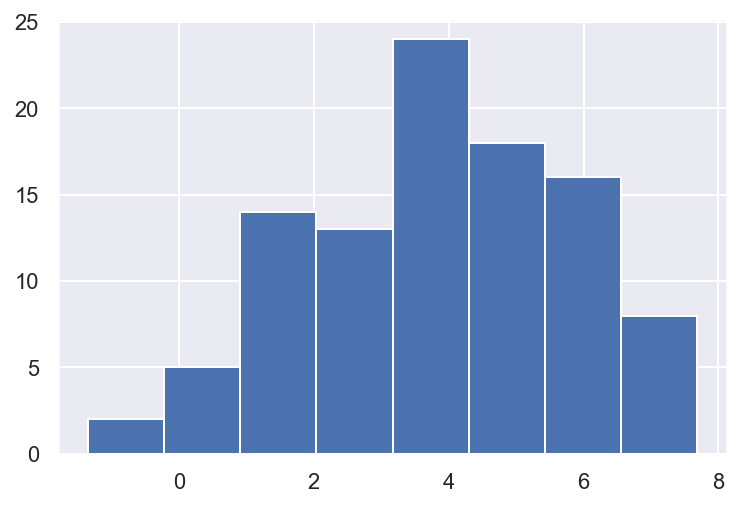

In [1213]:
fig, ax = plt.subplots()
ax.hist(obs.data.numpy(), bins='auto');

# Full batch

In [1214]:
flow_length = 16
epochs = 1000
initial_lr = 0.01
n_sample=40
dim = 2

In [1215]:
class Model:
    def __init__(self, dim, flow_length):
        super().__init__()
        self.dim = dim
        self.transforms = [T.Planar(dim) for _ in range(flow_length)]
        
        self.mu = torch.zeros(dim).uniform_(-0.01, 0.01)
        self.log_var = torch.zeros(dim).uniform_(-0.01, 0.01)
    
    @staticmethod
    def model():
        pass
    @staticmethod
    def guide():
        pass
    
    def loss(self, model, guide, X):
        
        q0_mu = pyro.param("mu", self.mu)
        q0_log_var = pyro.param("log_var", self.log_var)
        
        base_dist = dist.Normal(q0_mu, torch.exp(0.5*q0_log_var))
        flow_dist = dist.TransformedDistribution(base_dist, self.transforms)
        
        pyro.module("nf", nn.ModuleList(self.transforms))
        with pyro.plate("n_sample", 40):
            zk = pyro.sample("zk", flow_dist)

        mu, log_var = zk.T
        sigma = torch.exp(0.5 * log_var)
        X = X.unsqueeze(-1)
        lls =  dist.Normal(mu, sigma).log_prob(X).sum(axis=0)
        ln_q = flow_dist.log_prob(zk)
    
        return (ln_q - lls).mean()
    
    def sample(self, n=40):
        
        base_dist = dist.Normal(self.mu,torch.exp(0.5*self.log_var))
        flow_dist = dist.TransformedDistribution(base_dist, self.transforms)
        
        with pyro.plate("n_sample", n):
            zk = pyro.sample("zk", flow_dist)
        return zk

In [1216]:
torch.manual_seed(123);
pyro.clear_param_store()

In [1217]:
model = Model(dim=2, flow_length=16)

In [1218]:
model.mu

tensor([-0.0040,  0.0004])

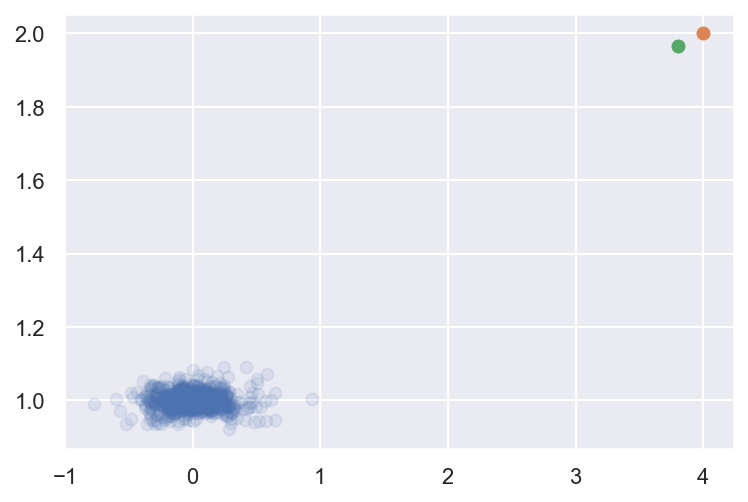

In [1219]:
zk = model.sample(1000)
mu, log_var = zk.T
sigma = torch.exp(0.5 * log_var)

fig, ax = plt.subplots()
ax.scatter(mu.data, sigma.data, alpha=0.1)
ax.scatter(true_mu, true_sigma)
ax.scatter(obs_mu, obs_sigma)

In [1220]:
optimizer = pyro.optim.Adam({"lr": 0.01})  #  "betas": (0.90, 0.999)})
svi = pyro.infer.SVI(model.model, model.guide, optimizer, model.loss)

pyro.clear_param_store()

hist_loss = []

with tqdm(total=epochs) as pbar:

    for i in range(epochs):

        loss = svi.step(obs)

        hist_loss.append(loss)

        pbar.set_postfix(loss=loss)
        pbar.update()

  0%|          | 0/1000 [00:00<?, ?it/s]

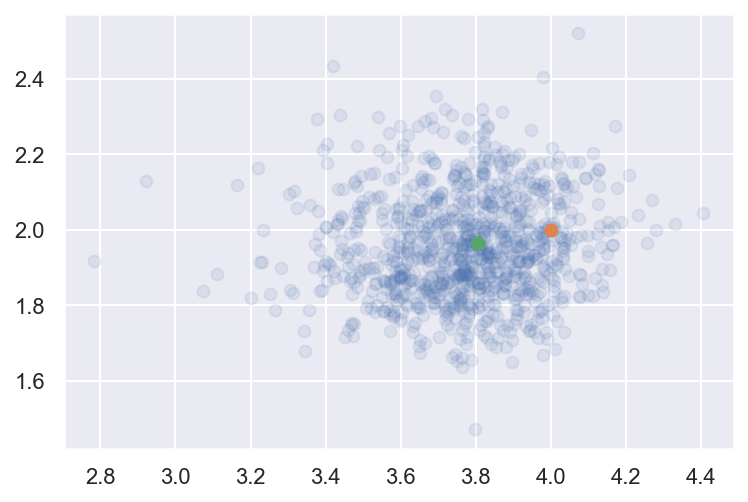

In [1221]:
zk = model.sample(1000)
mu, log_var = zk.T
sigma = torch.exp(0.5 * log_var)

fig, ax = plt.subplots()
ax.scatter(mu.data, sigma.data, alpha=0.1)
ax.scatter(true_mu, true_sigma)
ax.scatter(obs_mu, obs_sigma)

In [1222]:
model.mu

tensor([0.2777, 0.0309], requires_grad=True)

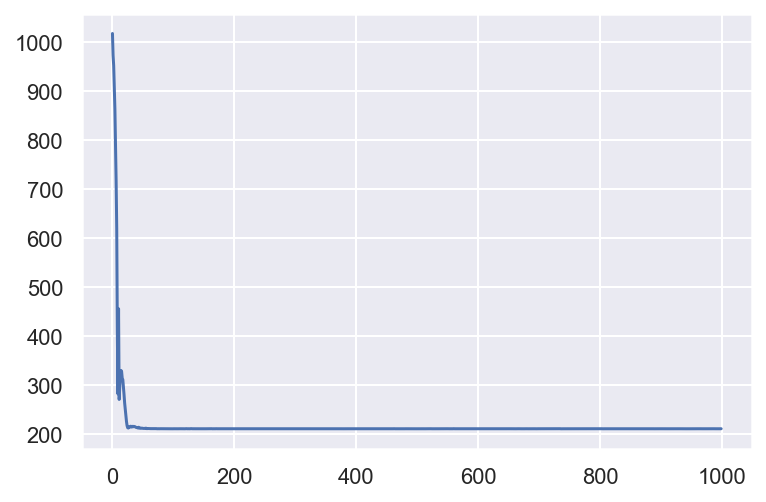

In [1223]:
plt.plot(hist_loss)

In [780]:
mu_samples = mu.detach()
log_var_samples = log_var.detach()

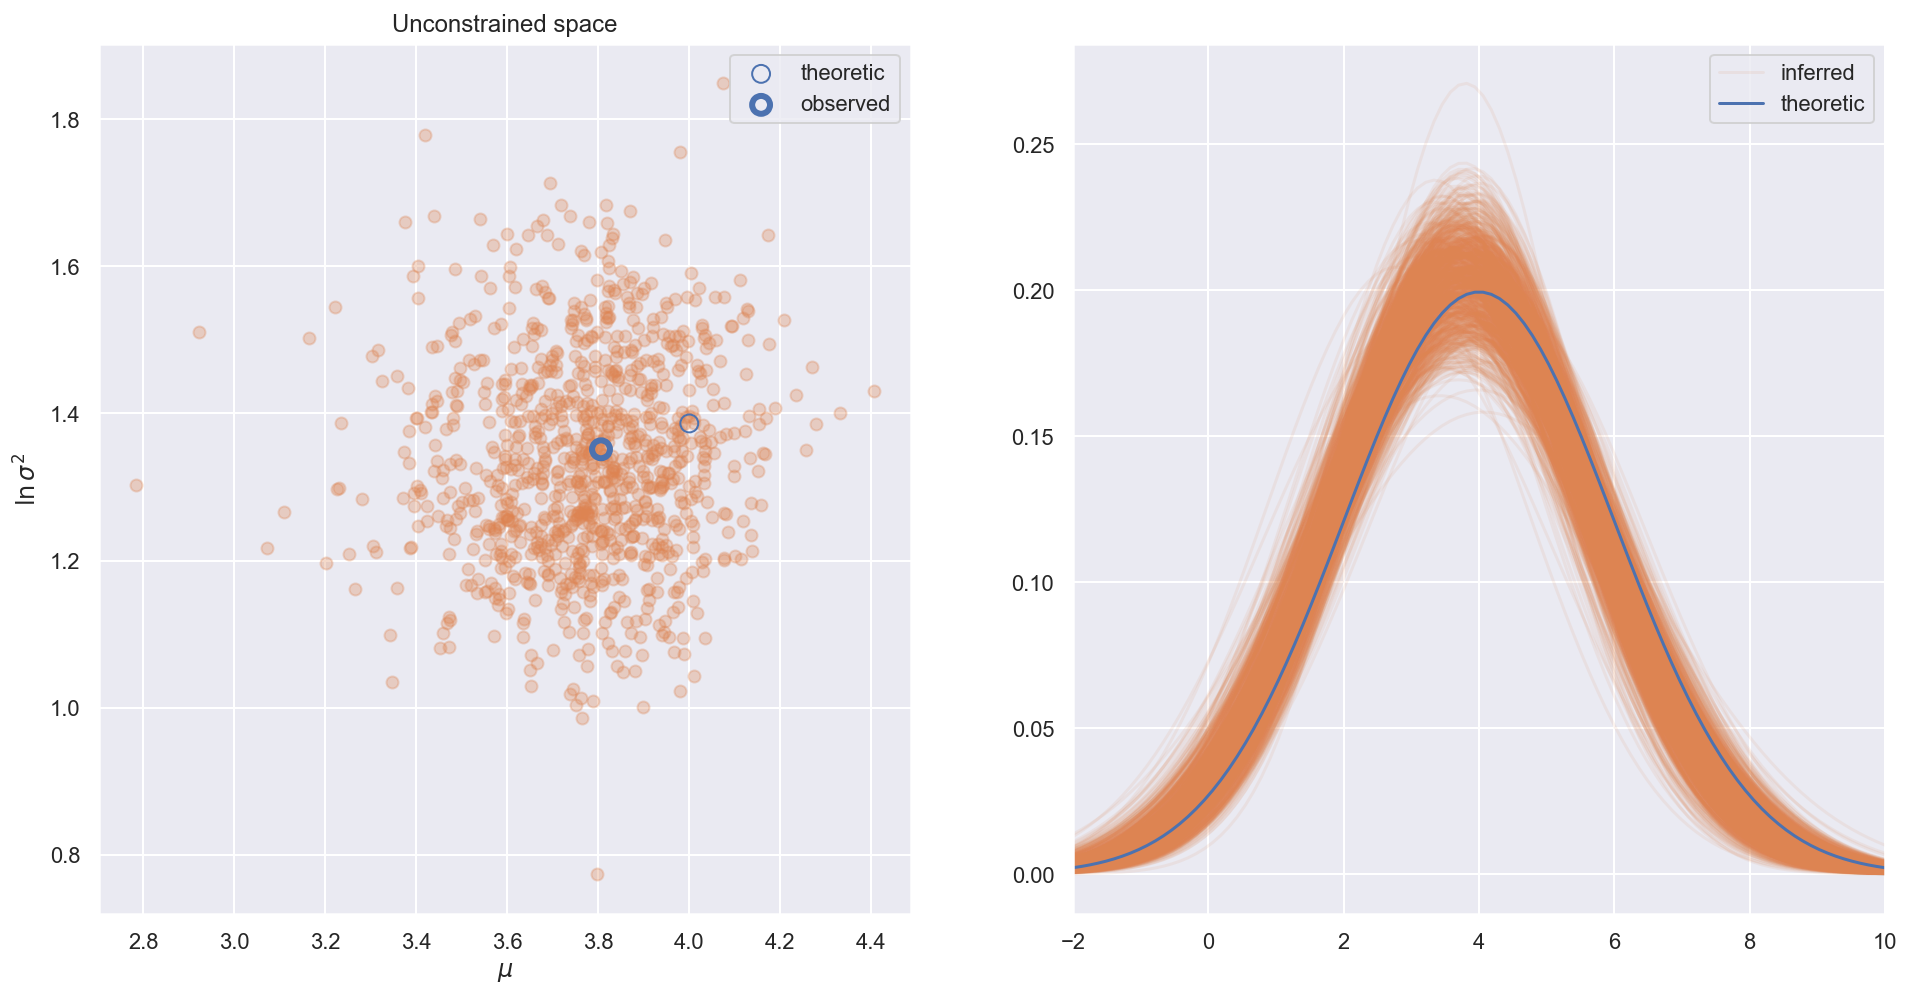

In [781]:
plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    mu_samples=mu_samples, log_var_samples=log_var_samples)

# Minibatch

In [784]:
batch_size=10
epochs=1000
flow_length=16
initial_lr=0.005 
n_sample=40 
seed=123
    
torch.manual_seed(seed)

model = Model(dim=n_dim, flow_length=flow_length)

optimizer = pyro.optim.Adam({"lr": 0.01})  #  "betas": (0.90, 0.999)})
svi = pyro.infer.SVI(model.model, model.guide, optimizer, model.loss)

pyro.clear_param_store()

hist_loss = []

with tqdm(total=epochs) as pbar:

    for epoch in range(epochs):

        permutation = torch.randperm(n_obs)

        for i in range(0, n_obs, batch_size):

            indices = permutation[i:i+batch_size]
            minibatch = obs[indices]
            
            loss = svi.step(minibatch)
            
            hist_loss.append(loss)

        pbar.set_postfix(loss=np.mean(hist_loss[- batch_size:]))
        pbar.update()

  0%|          | 0/1000 [00:00<?, ?it/s]

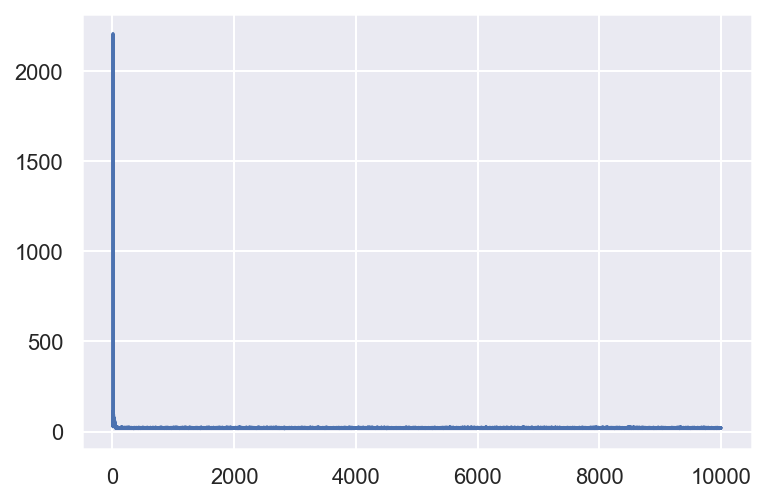

In [785]:
plt.plot(hist_loss);

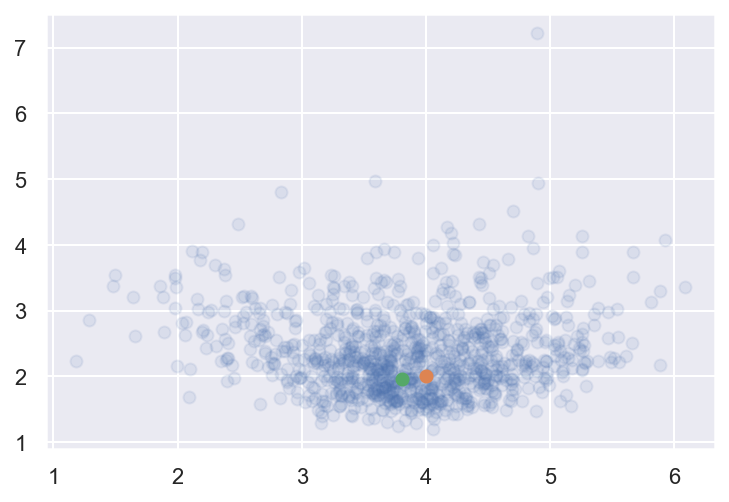

In [786]:
zk = model.sample(1000)
mu, log_var = zk.T
sigma = torch.exp(0.5 * log_var)

mu_samples = mu.detach()
log_var_samples = log_var.detach()

fig, ax = plt.subplots()
ax.scatter(mu.data, sigma.data, alpha=0.1)
ax.scatter(true_mu, true_sigma)
ax.scatter(obs_mu, obs_sigma)

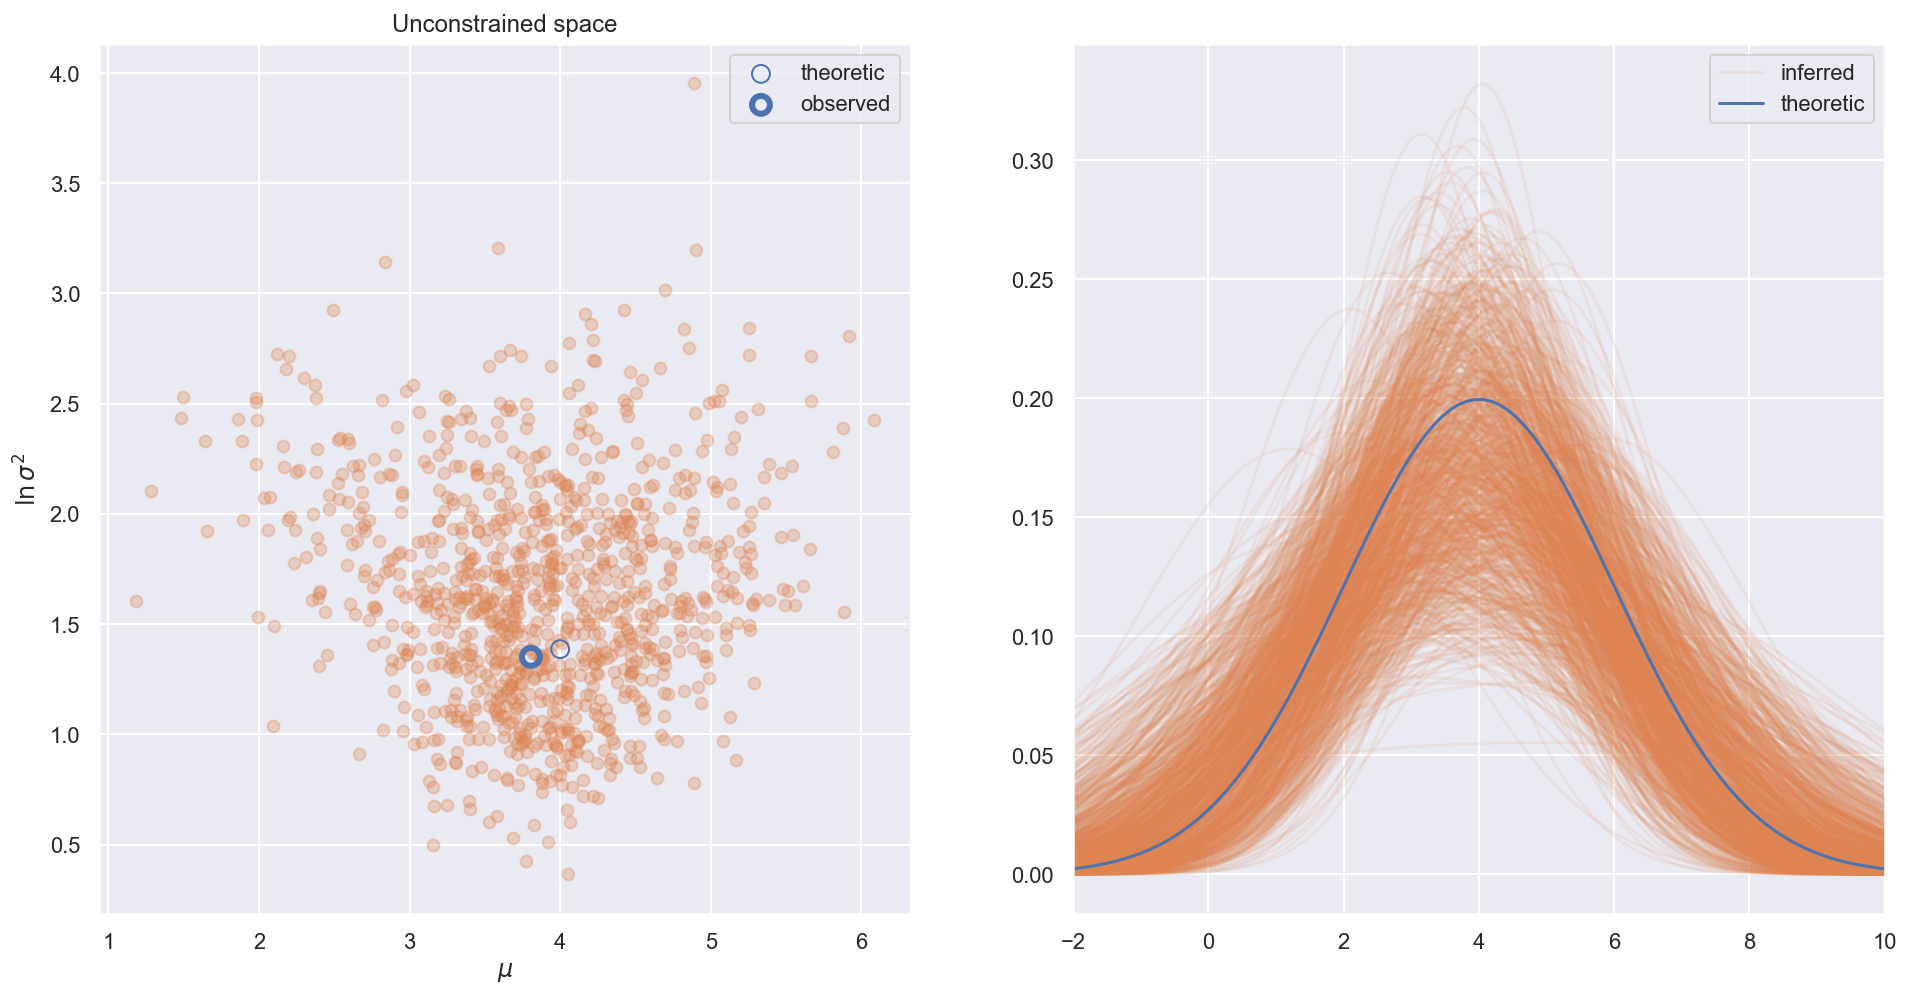

In [787]:
plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    mu_samples=mu_samples, log_var_samples=log_var_samples)

# Original example

In [689]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

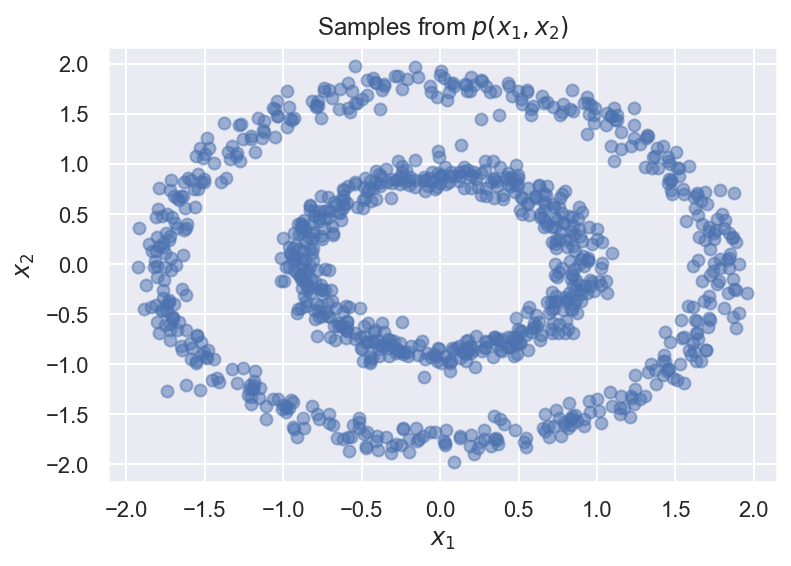

In [690]:
n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

In [696]:
dataset = torch.tensor(X, dtype=torch.float)

In [697]:
base_dist = dist.Normal(torch.zeros(dim), torch.ones(dim))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [698]:
pyro.clear_param_store()

optimizer = optim.Adam(
    spline_transform.parameters(),
    lr=0.01)

hist_loss = []

with tqdm(total=epochs) as pbar:

    for i in range(epochs):

        optimizer.zero_grad()

        loss = - flow_dist.log_prob(dataset).mean()
        loss.backward()
        optimizer.step()
        flow_dist.clear_cache()

        hist_loss.append(loss.item())

        pbar.set_postfix(loss=loss.item())
        pbar.update()

  0%|          | 0/1000 [00:00<?, ?it/s]

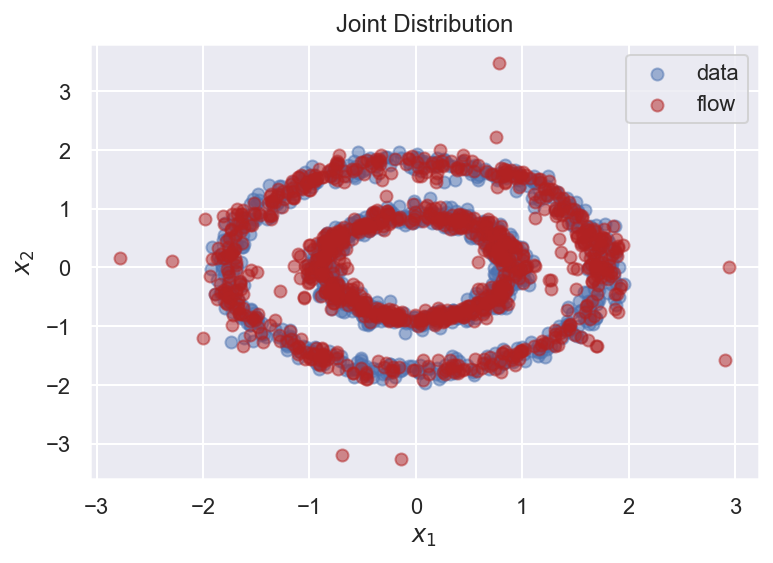

In [719]:
fig, ax = plt.subplots()

X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
ax.set_title(r'Joint Distribution')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
ax.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
ax.legend();

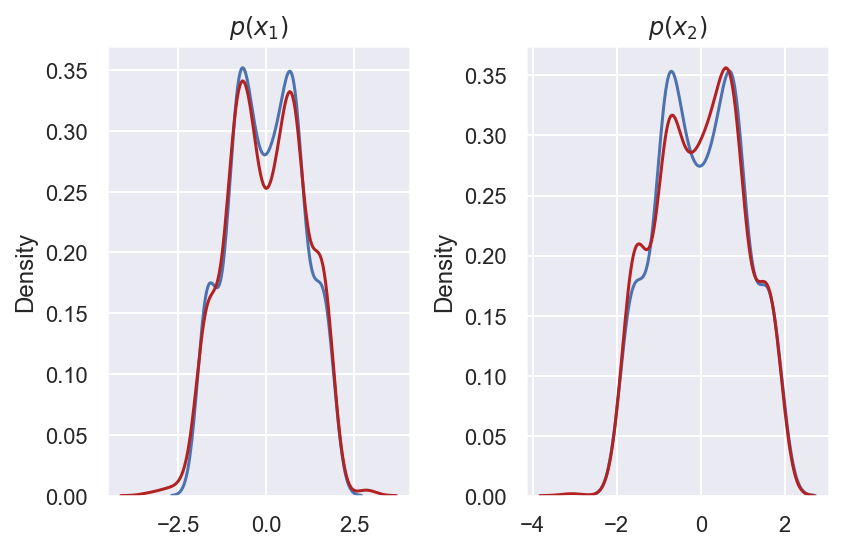

In [717]:
fig, axes = plt.subplots(ncols=2)
sns.kdeplot(X[:,0], label='data', ax=axes[0])
sns.kdeplot(X_flow[:,0], color='firebrick', label='flow', ax=axes[0])
axes[0].set_title(r'$p(x_1)$')

sns.kdeplot(X[:,1], label='data', ax=axes[1])
sns.kdeplot(X_flow[:,1], color='firebrick', label='flow', ax=axes[1])
axes[1].set_title(r'$p(x_2)$')
fig.tight_layout()

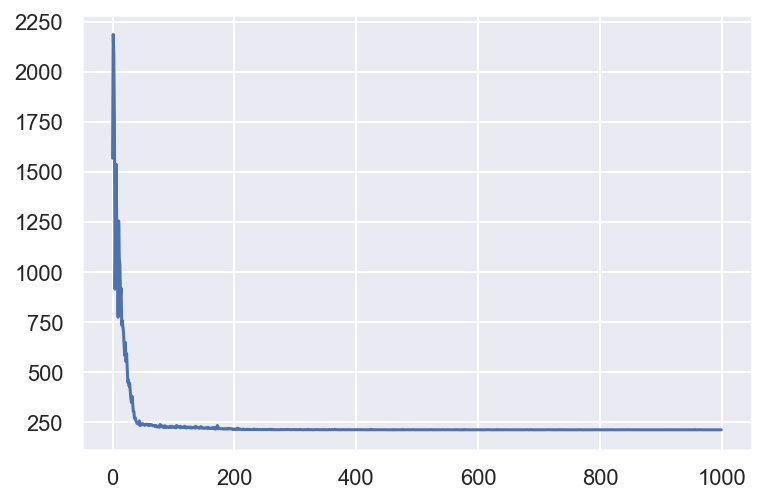

In [47]:
plt.plot(hist_loss);